### Brief Introduction to Random Forests

Random Forest Algorithms are basically Bagging (Short for **Bootstrap Aggregating**) Algorithms wherein you combine the output of certain number of Decision Trees. Random Forest ensures that the models built are truly random by ensuring two things,

1. Each Decision tree that is built is built on different set of data. i.e., rows or observations are selected at random with replacement. So basically, 67% of the rows in the data are represented in each tree built. It may happen that some of the observations are repeated multiple times and some obserations may not appear in a tree at all. This is basically the concept of **Bootstrapping**. 

2. The second thing which ensures randomness is by using few columns while building individual trees. One can use all of the columns while building the trees, but that will not ensure randomness and hence the output will not be generalized. 

The two aspects mentioned above ensure that the model built is generalized well on the out of sample data and does not overfit. 

Random Forests are also built with other mechanisms to control overfitting, some of them are as follows,

1. **Max_Depth**: This parameter controls the depth to which each tree is built. If you just consider 1 tree, then it does not make sense to build a tree with large depth as it will definitely overfit. But when you combine many such trees, it generalizes well. It should be kept in mind that **Deeper the tree, higher is the chance of overfitting.**

2. **n_estimators:** This parameter defines the number of trees you build. For a large dataset, it does not make sensse to use a large value as it leads to large training time. Typically, as you increase this parameter, the model generalizes well upto certain value, but the performance diminishes and training time increases if you choose a very high value.

3. **Max_Features:** This is the maximum number of features that can be used to build a tree. This is to ensure randomness while building a model. Typical values range from 0.5 to 0.9, Square root of the number of variables is also a good choice.

4. **class_weight:** This parameter is useful mostly in the case of imbalanced classification problems and we will see the importance of this parameter in the example below. 

5. **min_samples_leaf:** This defines the minimum number of samples that are supposed to be present in the leaf of the trees that we build. This parameter controls overfitting in the sense that lower the value, higher the chance of overfitting. If you set this value as 1, you are basically saying each observation should be in a leaf, which will lead to a massively overfit deep tree. 

6. **min_samples_split:** This parameter will define the minimum number of observations needed in a leaf to consider for splitting, if the number is less than this, the leaf is not split further. This parameter also controls overfitting. 

All these properties make the Random Forest Algorithms one of the most sought after algorithms for any kind of algorithms. 

In [362]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score,confusion_matrix,plot_confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder

In [363]:
# importing the data
train = pd.read_csv("train_LZdllcl.csv")
test  = pd.read_csv("test_2umaH9m.csv")

# preparing data for submission and removing the id column from both the datasets
Submission = test[['employee_id']]
for df in [train,test]:
    df.drop("employee_id",axis=1,inplace=True)

In [364]:
# check the shape
print ("Training Dataset Shape:{}".format(train.shape))
print ("Testing Dataset Shape:{}".format(test.shape))

Training Dataset Shape:(54808, 13)
Testing Dataset Shape:(23490, 12)


In [365]:
# checking missing values
(train.isna().sum()/len(train)).sort_values()

department              0.000000
region                  0.000000
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
length_of_service       0.000000
KPIs_met >80%           0.000000
awards_won?             0.000000
avg_training_score      0.000000
is_promoted             0.000000
education               0.043953
previous_year_rating    0.075244
dtype: float64

In [366]:
(test.isna().sum()/len(test)).sort_values()

department              0.000000
region                  0.000000
gender                  0.000000
recruitment_channel     0.000000
no_of_trainings         0.000000
age                     0.000000
length_of_service       0.000000
KPIs_met >80%           0.000000
awards_won?             0.000000
avg_training_score      0.000000
education               0.044019
previous_year_rating    0.077139
dtype: float64

In [367]:
train.head(3)

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0


In [368]:
test.head(3)

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47


### Exploratory Data Analysis

#### Dependent Variable

In [369]:
train['is_promoted'].value_counts(normalize=True)

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

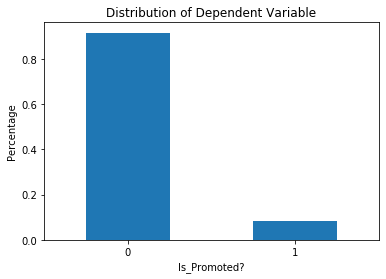

In [370]:
train['is_promoted'].value_counts(normalize=True).plot.bar();
plt.title("Distribution of Dependent Variable");
plt.xticks(rotation=360);
plt.xlabel("Is_Promoted?");
plt.ylabel("Percentage");

We can see that the dependent variable is highly skewed. Only 8.5% of the employees are promoted and the rest are not.

#### Independent Variables

#### Categorical Columns

In [371]:
cat_cols = ['department','region','gender','recruitment_channel','education']

In [372]:
for col in cat_cols:
    print ("Number of Unique values in the {} Categorical Variable are:{}".format(col,train[col].nunique()))

Number of Unique values in the department Categorical Variable are:9
Number of Unique values in the region Categorical Variable are:34
Number of Unique values in the gender Categorical Variable are:2
Number of Unique values in the recruitment_channel Categorical Variable are:3
Number of Unique values in the education Categorical Variable are:3


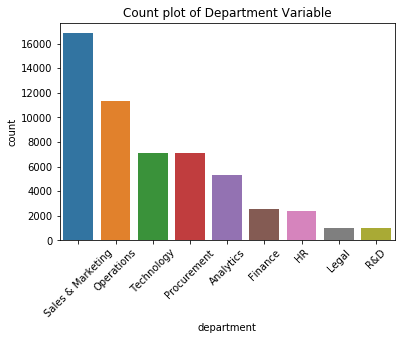

In [373]:
sns.countplot(train['department'],order=train['department'].value_counts().index);
plt.title("Count plot of Department Variable");
plt.xticks(rotation=45);

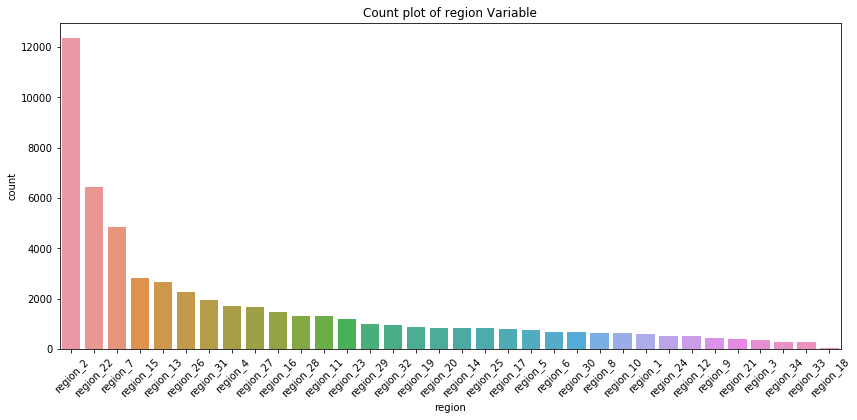

In [374]:
plt.figure(figsize=(14,6))
sns.countplot(train['region'],order=train['region'].value_counts().index);
plt.title("Count plot of region Variable");
plt.xticks(rotation=45);

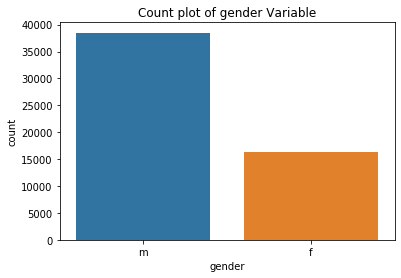

In [375]:
sns.countplot(train['gender'],order=train['gender'].value_counts().index);
plt.title("Count plot of gender Variable");

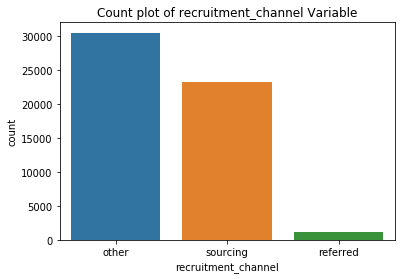

In [376]:
sns.countplot(train['recruitment_channel'],order=train['recruitment_channel'].value_counts().index);
plt.title("Count plot of recruitment_channel Variable");

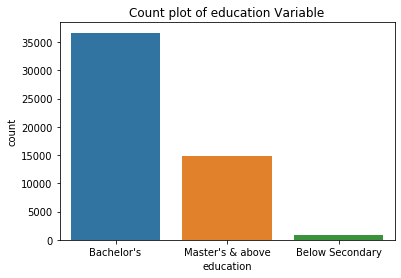

In [377]:
sns.countplot(train['education'],order=train['education'].value_counts().index);
plt.title("Count plot of education Variable");

In [378]:
# Let's check the distribution of the dependent variable Vs the categorical independent variables

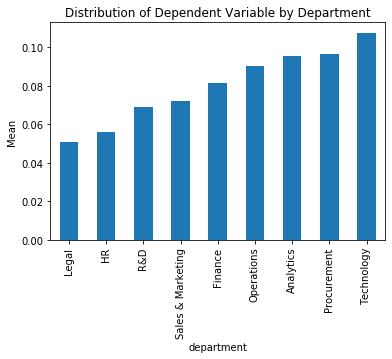

In [379]:
train.groupby("department")['is_promoted'].mean().sort_values().plot.bar();
plt.title("Distribution of Dependent Variable by Department");
plt.ylabel("Mean");

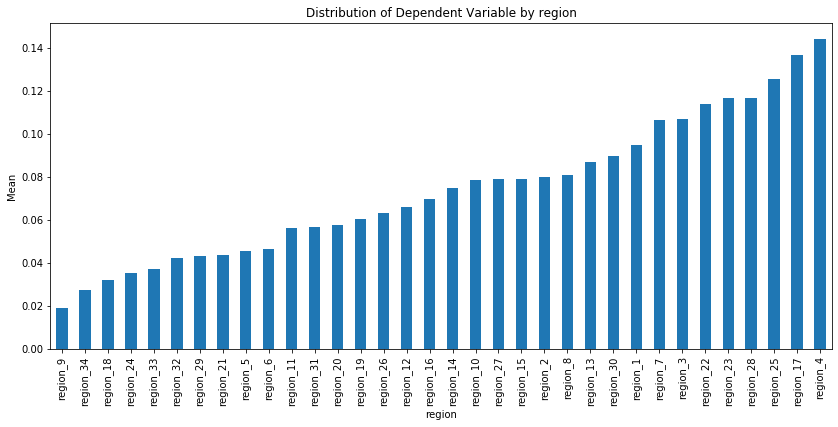

In [380]:
plt.figure(figsize=(14,6));
train.groupby("region")['is_promoted'].mean().sort_values().plot.bar();
plt.title("Distribution of Dependent Variable by region");
plt.ylabel("Mean");

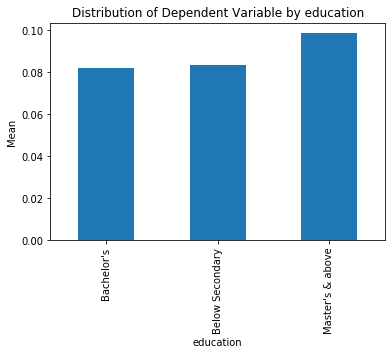

In [381]:
train.groupby("education")['is_promoted'].mean().sort_values().plot.bar();
plt.title("Distribution of Dependent Variable by education");
plt.ylabel("Mean");

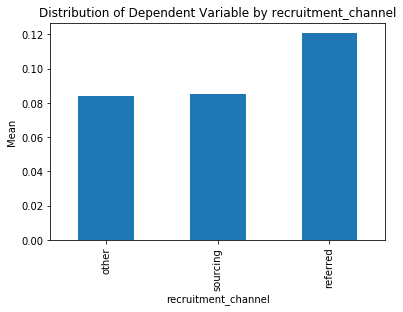

In [382]:
train.groupby("recruitment_channel")['is_promoted'].mean().sort_values().plot.bar();
plt.title("Distribution of Dependent Variable by recruitment_channel");
plt.ylabel("Mean");

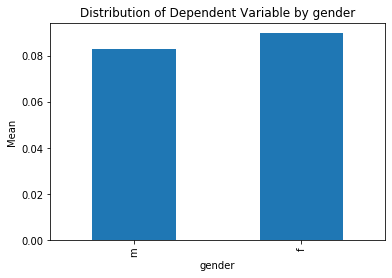

In [383]:
train.groupby("gender")['is_promoted'].mean().sort_values().plot.bar();
plt.title("Distribution of Dependent Variable by gender");
plt.ylabel("Mean");

Some observations from the Bar plots above are, 

1. Sales&Marketing, Operations and Technology are the major departments.
2. Ratio of Male and Female employees is 7:3.
3. Most of the employees are Bachelor degree holders and few of them are PhD holders. Very few are Below Secondary graduates.
4. Male and Female employees have almost equal chance of getting promoted. 
5. If you are referred, you have high chance of getting promoted, this might be because there are very few employees woh are referred.
6. Those who work in Technology department have high chance of getting promoted among other departments.

#### Numerical Variables

In [384]:
num_cols = ['no_of_trainings','age','previous_year_rating','length_of_service','KPIs_met >80%','awards_won?','avg_training_score']

In [385]:
train[num_cols].describe()

,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
count,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750
std,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559
min,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000
25%,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000
50%,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000
75%,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000
max,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000


Some observations from the above description are,

1. previous_year_rating has missing values mainly because this is their first year at the job.
2. Maximum and Minimum age are 60 and 20 respectively. Average age is 35.
3. Average number of trainings attended is 1.25 with maximum being 10.
4. Average rating is 3.3 with Maximum of 5 and Minimum of 1.
5. Maximum and Minimum length of service is 37 and 1 respectively.
6. 35% of the employees have met their KPI's.
7. Only 2.3% of the employees have won an award.

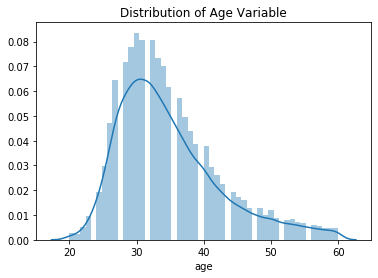

In [386]:
sns.distplot(train['age']);
plt.title("Distribution of Age Variable");
# The plot looks marginally skewed to the right. 

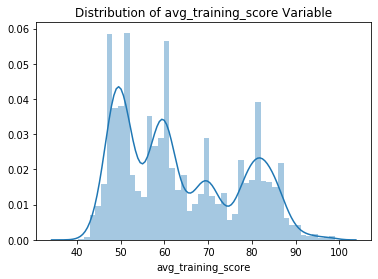

In [387]:
sns.distplot(train['avg_training_score']);
plt.title("Distribution of avg_training_score Variable");
# There is no pattern evident from the distribution plot above. 

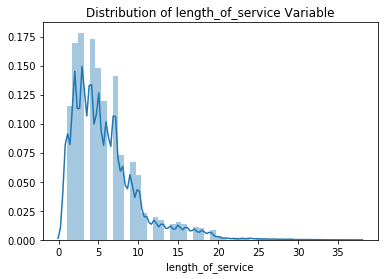

In [388]:
sns.distplot(train['length_of_service']);
plt.title("Distribution of length_of_service Variable");
# This looks like positively skewed distribution.

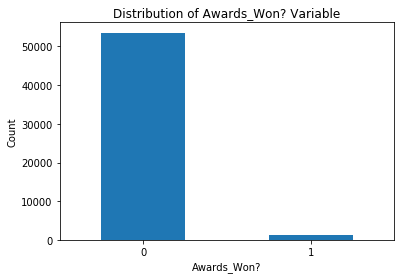

In [389]:
train['awards_won?'].value_counts().plot.bar();
plt.title("Distribution of Awards_Won? Variable");
plt.xticks(rotation=360);
plt.xlabel("Awards_Won?");
plt.ylabel("Count");

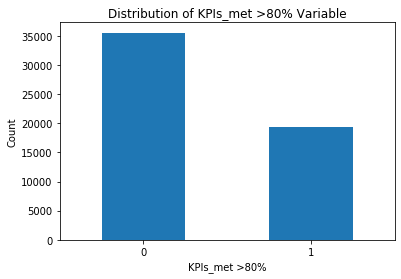

In [390]:
train['KPIs_met >80%'].value_counts().plot.bar();
plt.title("Distribution of KPIs_met >80% Variable");
plt.xticks(rotation=360);
plt.xlabel("KPIs_met >80%");
plt.ylabel("Count");

#### Bi-Variate Analysis

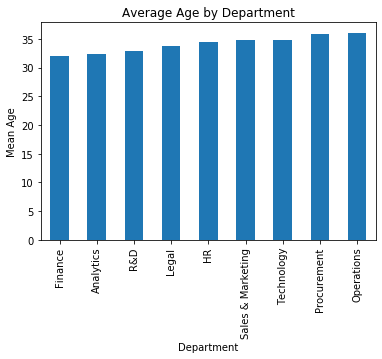

In [391]:
train.groupby("department")['age'].mean().sort_values().plot.bar();
plt.title("Average Age by Department");
plt.xlabel("Department");
plt.ylabel("Mean Age");

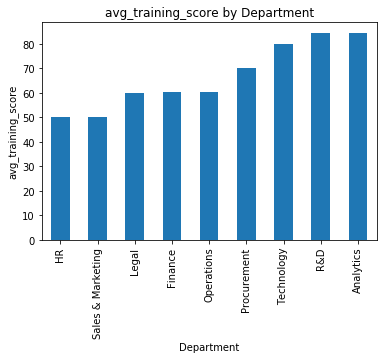

In [392]:
train.groupby("department")['avg_training_score'].mean().sort_values().plot.bar();
plt.title("avg_training_score by Department");
plt.xlabel("Department");
plt.ylabel("avg_training_score");

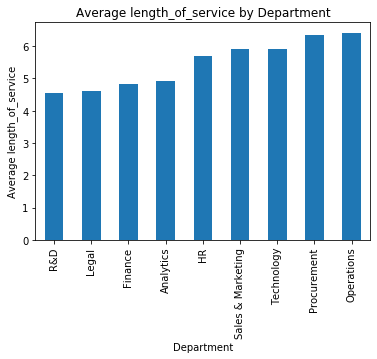

In [393]:
train.groupby("department")['length_of_service'].mean().sort_values().plot.bar();
plt.title("Average length_of_service by Department");
plt.xlabel("Department");
plt.ylabel("Average length_of_service");

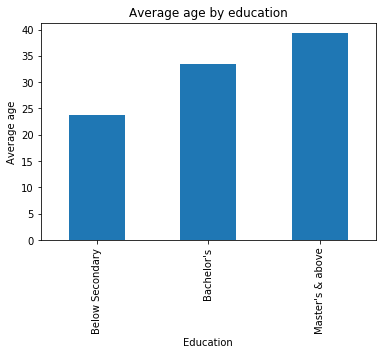

In [394]:
train.groupby("education")['age'].mean().sort_values().plot.bar();
plt.title("Average age by education");
plt.xlabel("Education");
plt.ylabel("Average age");
# As expected, the average age of Master's and above degree holders is higher compared to others.

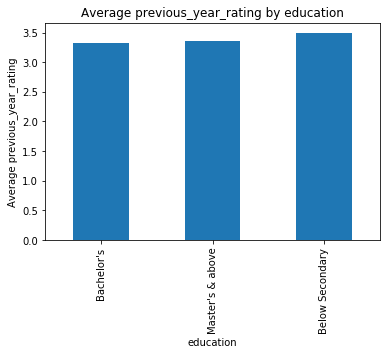

In [395]:
train.groupby("education")['previous_year_rating'].mean().sort_values().plot.bar();
plt.title("Average previous_year_rating by education");
plt.xlabel("education");
plt.ylabel("Average previous_year_rating");
# We see that employees education does not affect the rating at all. Average rating is same for all education levels. 

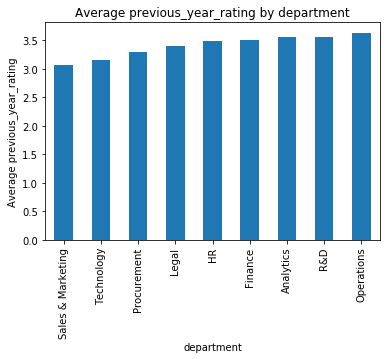

In [396]:
train.groupby("department")['previous_year_rating'].mean().sort_values().plot.bar();
plt.title("Average previous_year_rating by department");
plt.xlabel("department");
plt.ylabel("Average previous_year_rating");
# We see that employees department does not affect the rating much. Average rating is almost same for all departments . 

#### Missing Value Imputation & Feature Engineering

In [397]:
for df in [train,test]:
    df['Fresher?'] = np.where(df['previous_year_rating'].isna(),1,0)
    df['previous_year_rating'].fillna(0,inplace=True)
    df['education'].fillna("Missing",inplace=True)

In [398]:
le = LabelEncoder()
for df in [train,test]:
    for col in test.columns:
        if df[col].dtype=="object":
            df[[col]] = le.fit_transform(df[[col]]) 

C:\Users\kulka\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [399]:
y = train['is_promoted']
X = train[[col for col in train.columns if col!='is_promoted']]

In [400]:
# splitting the data into train and test sets
X_Train,X_Test,y_Train,y_Test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
print (X_Train.shape)
print (y_Train.shape)
print (X_Test.shape)
print (y_Test.shape)

(43846, 13)
(43846,)
(10962, 13)
(10962,)


In [401]:
# We can see below that the train and test sets have the same distribution of the dependent variable.

In [402]:
y_Train.value_counts()/len(y_Train)

0    0.914838
1    0.085162
Name: is_promoted, dtype: float64

In [403]:
y_Test.value_counts()/len(y_Test)

0    0.914797
1    0.085203
Name: is_promoted, dtype: float64

#### Model Building

In [404]:
# We will run two models initially, both will be run on all default parameter, but the only difference will be about the 
# class_weight parameter, in the first model, it will be set to default and in the second it will be set to balanced, then you
# can see the importance of this parameter in case of imbalanced classification problems.
clf = RandomForestClassifier(n_jobs=-1,random_state=42)
clf.fit(X_Train,y_Train)
train_pred = clf.predict(X_Train)
test_pred = clf.predict(X_Test)
print ("Training F1 Score is:{}".format(f1_score(y_Train,train_pred)))
print ("Testing F1 Score is:{}".format(f1_score(y_Test,test_pred)))

Training F1 Score is:0.9989284757567639
Testing F1 Score is:0.40161290322580645


We can see that the model is oerfitting massively, you can see it from the Training and Testing F1 Scores.

To show the importance of class__weight parameter, let's run another model with the parameter defined. 

In [405]:
clf_1 = RandomForestClassifier(n_jobs=-1,random_state=42,class_weight='balanced')
clf_1.fit(X_Train,y_Train)
train_pred = clf_1.predict(X_Train)
test_pred = clf_1.predict(X_Test)
print ("Training F1 Score is:{}".format(f1_score(y_Train,train_pred)))
print ("Testing F1 Score is:{}".format(f1_score(y_Test,test_pred)))

Training F1 Score is:0.9985276402088074
Testing F1 Score is:0.40325203252032515


We can see a slight improvement in the testing F1 Score, but after tuning other hyperparameters and using a good validation strategy, the score can be improved greatly.

#### Hyperparameter tuning and Cross Validation.

In [406]:
# defining the cross validation strategy
kf = StratifiedKFold(n_splits=5,shuffle=False,random_state=42)

# initiating the estimator
rf = RandomForestClassifier(n_jobs=-1,random_state=42)

# defining the search parameters
params = {"n_estimators":list(range(50,500,100)),
          "max_features":[0.5,'sqrt','log2',None],
          "max_depth":list(range(4,12,2)),
          "min_samples_leaf":[2,5,10,15,25,50],
          "min_samples_split":[2,5,10,15,20,25,50],
          "class_weight":[None,'balanced']}

# running the random search to find the right hyperparameters.
search = RandomizedSearchCV(estimator=rf,scoring="f1",cv=kf.split(X,y),n_jobs=-1,random_state=42,param_distributions=params)
search.fit(X,y)

C:\Users\kulka\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x000001654F316448>,
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,...
                   

In [407]:
search.best_estimator_,search.best_params_,search.best_score_

(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                        criterion='gini', max_depth=8, max_features=None,
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=5, min_samples_split=25,
                        min_weight_fraction_leaf=0.0, n_estimators=450,
                        n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 {'n_estimators': 450,
  'min_samples_split': 25,
  'min_samples_leaf': 5,
  'max_features': None,
  'max_depth': 8,
  'class_weight': 'balanced'},
 0.3467951447354848)

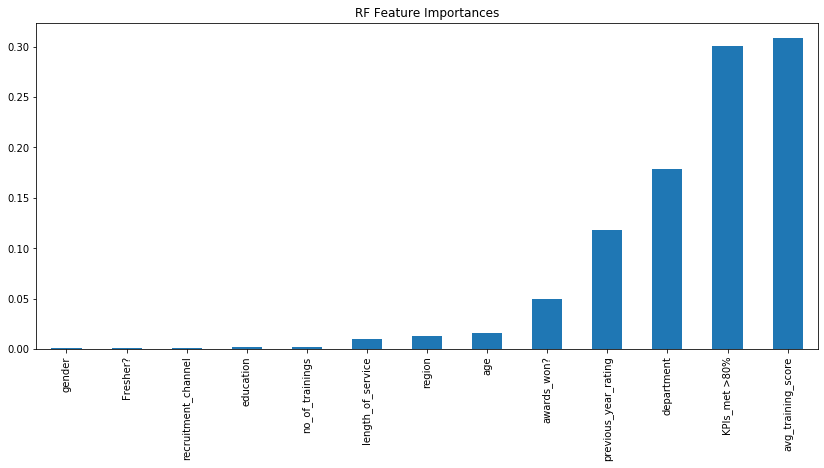

In [408]:
ser = pd.Series(search.best_estimator_.feature_importances_,X.columns).sort_values()
plt.figure(figsize=(14,6))
ser.plot(kind='bar');
plt.title("RF Feature Importances");

So, we can trust the CV score than the score we obtained with the help of train test split method which led to overfitting. 